# Generate PC database
Here we compute the mean large-scale flow associated with each PF and project it onto the EOFs of vertical mass flux

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython.display import clear_output
from src.configs import *
from src.plotting import *
from src.regions import *
from src.pcs import *

In [2]:
REGION = 'AFC'
RADIUS_IN_DEGS = 5  # RADIUS AROUND PFs TO USE IN COMPUTING ac and as

In [3]:
pf_ds = load_pf_stats(REGION)
pf_ds = pf_ds.where(pf_ds.mean_latitude.abs() < 10).dropna()

In [4]:
pf_lat = pf_ds.mean_latitude.values
pf_lon = pf_ds.mean_longitude.values
pf_time = pd.to_datetime(pf_ds.observation_time, format='%Y%m%d_%H:%M:%S')
pf_day = pf_time.dt.floor('D').values

In [11]:
era5_w = xr.open_dataset(merged_era5_var_file('W')).W
era5_w['time'] = era5_w['time'].dt.floor('D')
era5_w['lon'] = era5_w['lon'] - 180

In [12]:
eofs = load_era5_eofs(REGION)

In [13]:
def lat_lon_grid_slice(lat0, lon0, time0, radius_in_degs=5):
    slice_dict = {
        'lat': slice(lat0-radius_in_degs/2, lat0+radius_in_degs/2),
        'lon': slice(lon0-radius_in_degs/2, lon0+radius_in_degs/2),
        'time': time0
    }
    return slice_dict

In [14]:
grid_slices = [lat_lon_grid_slice(lat0, lon0, time0, radius_in_degs=5) for (lat0, lon0, time0) in zip(pf_lat, pf_lon, pf_day)]

In [15]:
pc_database_dict = init_pc_database_dict()
for i, gs in enumerate(grid_slices):
    clear_output()
    print(f'PF {i+1} of {len(grid_slices)} ')
    obs_w = era5_w.sel(gs)
    assert(obs_w.lat.size>0 and obs_w.lon.size>0)
    pf_mf = (-1/9.81)*obs_w.mean(('lat', 'lon'))
    pc_database_dict['pc1'].append((eofs.sel(mode=1) * pf_mf).sum().item())
    pc_database_dict['pc2'].append((eofs.sel(mode=2) * pf_mf).sum().item())
pc_database = pd.DataFrame.from_dict(pc_database_dict)

PF 41584 of 41584 


In [14]:
pf_ds.join(pc_database).to_csv(f'{project_root_dir()}/data/{REGION}.tropical_pf_pc_data_5deg.csv')

# What is the large-scale circulation associated with PFs?

In [172]:
pf_ds = pd.read_csv(f'{project_root_dir()}/data/{REGION}.tropical_pf_pc_data_5deg.csv')

In [173]:
pr = (pf_ds.total_precip/pf_ds.num_pixels)
epe_id = pr >= pr.quantile(0.99)
epe_df = pf_ds.where(epe_id).dropna()

Text(0, 0.5, 'Normed_PC2')

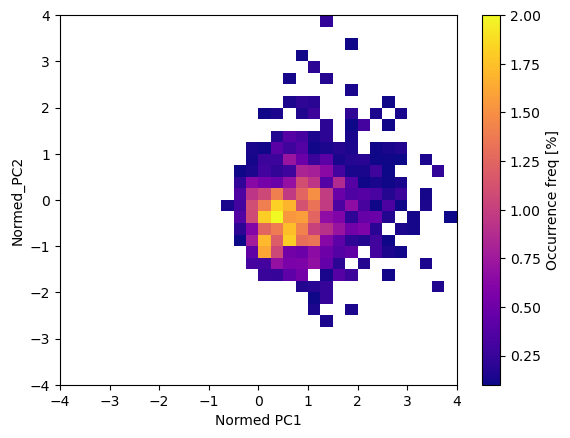

In [176]:
pc1_normed = pf_ds['pc1']/pf_ds['pc1'].std()
pc2_normed = pf_ds['pc2']/pf_ds['pc2'].std()
pc_bins = np.arange(-10, 10, 0.25)
# Create the 2D histogram
hist, xedges, yedges = np.histogram2d(pc1_normed, pc2_normed, bins=[pc_bins, pc_bins])

# Plot the 2D histogram
fig, ax = plt.subplots()

X, Y = np.meshgrid(xedges, yedges)
cmap = plt.cm.plasma.copy()
cmap.set_under('white')
norm = colors.Normalize(vmin=1e-1, vmax=2)
c = ax.pcolormesh(X, Y, 100*hist.T/hist.sum(), cmap=cmap, norm=norm)
fig.colorbar(c, ax=ax, label='Occurrence freq [%]')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel('Normed PC1')
ax.set_ylabel('Normed_PC2')

In [149]:
pc1_normed = pf_ds['pc1']/pf_ds['pc1'].std()
pc2_normed = pf_ds['pc2']/pf_ds['pc2'].std()
pc_bins = np.arange(-10, 10, 0.25)
# Create the 2D histogram
hist, xedges, yedges = np.histogram2d(pc1_normed, pc2_normed, bins=[pc_bins, pc_bins])

# Plot the 2D histogram
fig, ax = plt.subplots()

X, Y = np.meshgrid(xedges, yedges)
cmap = plt.cm.plasma.copy()
cmap.set_under('white')
norm = colors.Normalize(vmin=1e-1, vmax=2)
c = ax.pcolormesh(X, Y, 100*hist.T/hist.sum(), cmap=cmap, norm=norm)
fig.colorbar(c, ax=ax, label='Occurrence freq [%]')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel('Normed PC1')
ax.set_ylabel('Normed_PC2')

1268.0

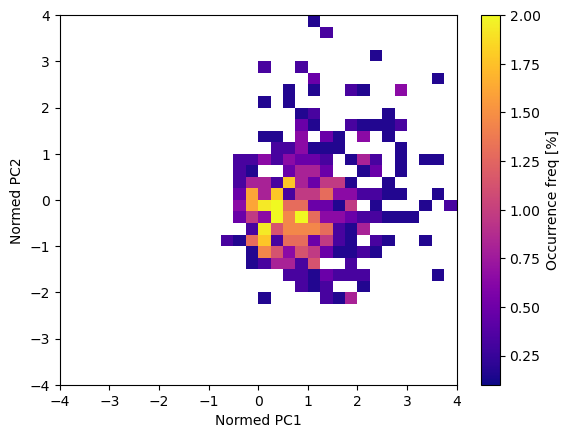

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Normalizing PC1 and PC2
pc1_normed = epe_df['pc1'] / epe_df['pc1'].std()
pc2_normed = epe_df['pc2'] / epe_df['pc2'].std()

# Define the bin edges
pc_bins = np.arange(-10, 10, 0.25)

# Create the 2D histogram
hist, xedges, yedges = np.histogram2d(pc1_normed, pc2_normed, bins=[pc_bins, pc_bins])

# Plot the 2D histogram
fig, ax = plt.subplots()

X, Y = np.meshgrid(xedges, yedges)
cmap = plt.cm.plasma.copy()
cmap.set_under('white')
norm = colors.Normalize(vmin=1e-1, vmax=2)
c = ax.pcolormesh(X, Y, 100 * hist.T / hist.sum(), cmap=cmap, norm=norm)

# Add color bar, labels, and set axis limits
fig.colorbar(c, ax=ax, label='Occurrence freq [%]')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel('Normed PC1')
ax.set_ylabel('Normed PC2')

plt.show()
